In [43]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

### L'étude dure 2h30 soit 9000 s (validé par figure 1)
Chaque activité prend comme temps :
* Sitting 10 min -> 600 s
* Stairs 5 min -> 300 s
* Table Soccer 5min -> 300 s
* Cycling 8 min -> 480 s
* driving car 15 min -> 900 s
* Lunch break 30 min -> 1800 s
* Walking 1min -> 600 s
* Working 8 min -> 1200 s


Nous allons dans un premier temps étudier le sujet 7 afin de comparer à la figure 1

In [2]:
chemin = 'C:/Users/Elise/Documents/Esilv/5emeAnnee/PythonForDataAnalysis/Projet/PPG_FieldStudy/S7/S7.pkl'
data =  pd.read_pickle(chemin)

In [3]:
data

{'rpeaks': array([    633,    1428,    2197, ..., 6538533, 6539057, 6539681]),
 'signal': {'chest': {'ACC': array([[ 0.87160003,  0.02540004, -0.15560001],
          [ 0.87100005,  0.02260005, -0.15859997],
          [ 0.87020004,  0.02320004, -0.15899998],
          ...,
          [ 0.93079996, -0.06120002, -0.2062    ],
          [ 0.93060005, -0.0564    , -0.21259999],
          [ 0.93120003, -0.0546    , -0.21380001]]),
   'ECG': array([[ 0.12437439],
          [ 0.13188171],
          [ 0.13829041],
          ...,
          [-0.08843994],
          [-0.08757019],
          [-0.08258057]]),
   'EMG': array([[-1.5],
          [-1.5],
          [-1.5],
          ...,
          [-1.5],
          [-1.5],
          [-1.5]]),
   'EDA': array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]),
   'Temp': array([[-273.15],
          [-273.15],
          [-273.15],
          ...,
          [-273.15],
          [-273.15],
          [-273.15

# 1) Analyse de données

In [4]:
print('Nombre de keys : ' + str(len(data.keys())) )
print('Nom des keys : ' + str(data.keys()))

Nombre de keys : 6
Nom des keys : dict_keys(['rpeaks', 'signal', 'label', 'activity', 'questionnaire', 'subject'])


In [5]:
print('Sujet : ' + str(data['subject']))
print('Caractéristique du sujet : '+ str(data['questionnaire']))

Sujet : S7
Caractéristique du sujet : {'WEIGHT': 58.0, 'Gender': ' f', 'AGE': 21, 'HEIGHT': 168.0, 'SKIN': 3, 'SPORT': 2}


Le label est les valeurs des battements de coeur mesurés sur 8 secondes avec 2 secondes de repos, reporté sur 1 min
La moyenne des battements par minute est : 86.68667454907391
Le nombre de battements minimum par minute est : 48.63469322902146
Le nombre de battements maximum par minute est : 152.9134108074917


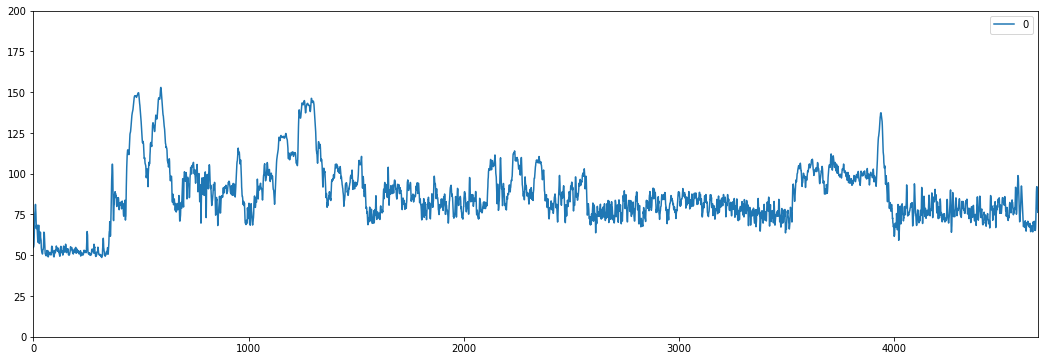

In [6]:
print('Le label est les valeurs des battements de coeur mesurés sur 8 secondes avec 2 secondes de repos, reporté sur 1 min')
print('La moyenne des battements par minute est : ' +str(data['label'].mean()))
print('Le nombre de battements minimum par minute est : ' +str(data['label'].min()))
print('Le nombre de battements maximum par minute est : ' +str(data['label'].max()))
label = pd.DataFrame(data['label'])
label.plot(yticks=range(0,225,25),figsize=(18,6))

## On met à l'échelle des 9000 s

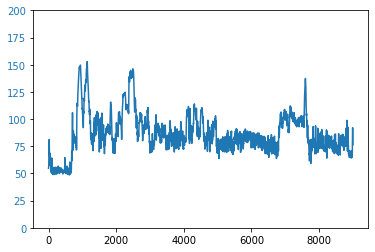

In [79]:
fig, ax = plt.subplots()

color = 'tab:blue'
ax.plot(label.index*(9000/len(label)), label, color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.set_yticks(range(0,225,25))
plt.show()

On affiche le nombre de fois où on a réalisé l'activité : 
Transient periods(ID: 0)
Sitting (ID: 1)
Ascending and descending stairs (ID: 2)
Table soccer (ID: 3): Playing table soccer
Cycling (ID: 4)
Driving a car (ID: 5)
Lunch break (ID: 6)
Walking (ID: 7)
Working (ID: 8)


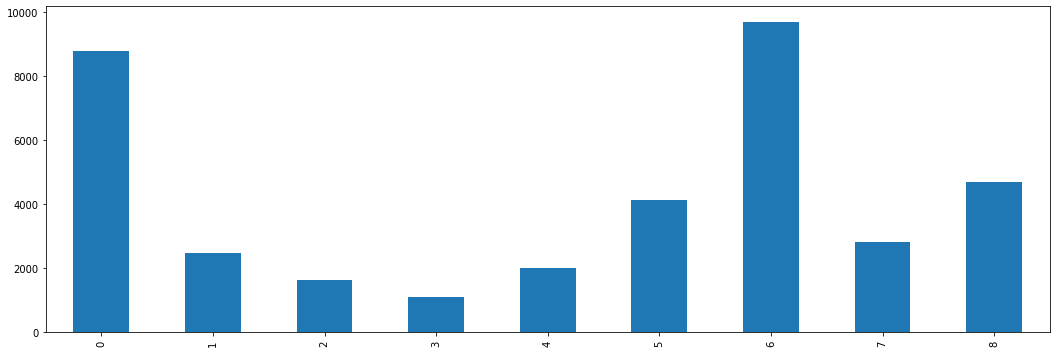

In [8]:
dfactivity = pd.DataFrame(data['activity'])
#On ajoute la colonne ci-après afin de pouvoir sommer
dfactivity["nb"] = 1
activity = dfactivity.groupby([0], as_index=False).sum()
print('On affiche le nombre de fois où on a réalisé l\'activité : ')
print('Transient periods(ID: 0)\nSitting (ID: 1)\nAscending and descending stairs (ID: 2)\nTable soccer (ID: 3): Playing table soccer\nCycling (ID: 4)\nDriving a car (ID: 5)\nLunch break (ID: 6)\nWalking (ID: 7)\nWorking (ID: 8)')
activity['nb'].plot(kind = "bar", figsize=(18,6))

## J'essaie de retrouver le même schéma que la figure 1

In [22]:
print('Nombre de secondes que dure une activité : ' + str(9000/len(pd.DataFrame(data['activity']))))

Nombre de secondes que dure une activité : 0.24082200577972815


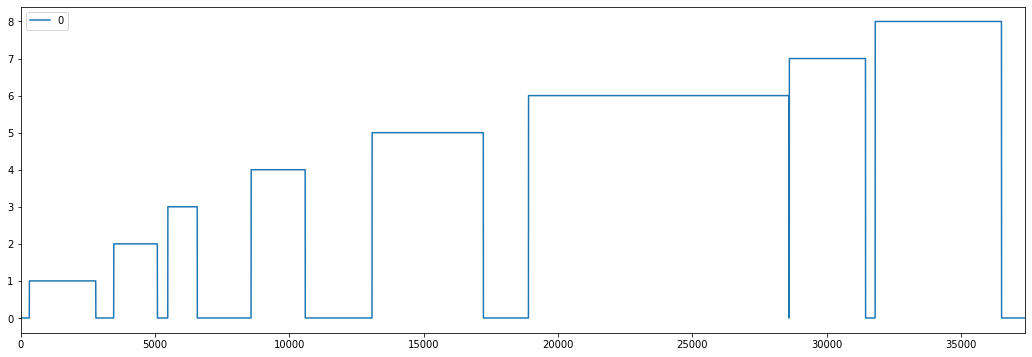

In [23]:
dfactivity = pd.DataFrame(data['activity'])
dfactivity.plot(figsize=(18,6))

## On met à l'échelle des 9000 s

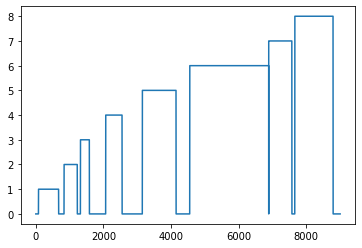

In [62]:
dfactivity = pd.DataFrame(data['activity'])
plt.plot(dfactivity.index*(9000/len(dfactivity)), dfactivity)

plt.show()

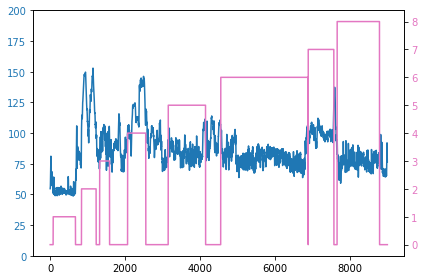

In [81]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.plot(label.index*(9000/len(label)), label, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks(range(0,225,25))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:pink'
ax2.plot(dfactivity.index*(9000/len(dfactivity)), dfactivity, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [55]:
pd.DataFrame(data["signal"])

,chest,wrist
ACC,"[[0.8716000318527222, 0.02540004253387451, -0....","[[-0.921875, -0.109375, -0.25], [-0.921875, -0..."
BVP,NaN,"[[-45.17], [-50.1], [-54.31], [-57.82], [-61.0..."
ECG,"[[0.1243743896484375], [0.1318817138671875], [...",NaN
EDA,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.140921], [0.140921], [0.13964], [0.142202]..."
EMG,"[[-1.5], [-1.5], [-1.5], [-1.5], [-1.5], [-1.5...",NaN
Resp,"[[1.31683349609375], [1.300048828125], [1.3259...",NaN
TEMP,NaN,"[[30.57], [30.57], [30.57], [30.57], [30.59], ..."
Temp,"[[-273.15], [-273.15], [-273.15], [-273.15], [...",NaN


NameError: name 'range' is not defined